In [1]:
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})
plt.rcParams["font.family"] = "serif"

import qiskit
from qiskit import Aer, execute
from qiskit import QuantumCircuit, QuantumRegister
from qiskit import IBMQ
from qiskit.circuit import ClassicalRegister
from qiskit.compiler import transpile

In [2]:
IBMQ.load_account() # Load account from disk
print(IBMQ.providers())    # List all available providers
provider = IBMQ.get_provider(hub='ibm-q-ornl')

/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>]


In [3]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>,
 <IBMQBackend('ibmq_paris') from IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>,
 <IBMQBackend('ibmq_rome') from IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-ornl', group='lbnl', project='hep126')>,
 <IBMQBackend('ibmq_manhattan') from IBMQ(hub='ibm-q-ornl', group='lbnl', proje

In [4]:
backend = provider.get_backend('ibmq_manhattan')
#coupling_map = backend.configuration().coupling_map

circs = []

nmult = 10

for i in range(nmult):
    qr = QuantumRegister(64, 'qr')
    cr = ClassicalRegister(64, 'cr')
    circ = QuantumCircuit(qr, cr)

    for q in range(64):
        circ.measure(q,q)

    circ.name='nom_'+str(i)
    mapped_circuit = transpile(circ, backend=backend, optimization_level=0)
    circs+=[mapped_circuit]
    
for j in range(nmult):
    for i in range(64):

        qr = QuantumRegister(64, 'qr')
        cr = ClassicalRegister(64, 'cr')
        circ = QuantumCircuit(qr, cr)

        circ.x(qr[i])

        circ.name='cal_'+str(i)+"_"+str(j)

        for q in range(64):
            circ.measure(q,q)

        mapped_circuit = transpile(circ, backend=backend, optimization_level=0)
        circs+=[mapped_circuit]
    
for i in range(nmult):
    qr = QuantumRegister(64, 'qr')
    cr = ClassicalRegister(64, 'cr')
    circ = QuantumCircuit(qr, cr)
    
    for i in range(64):
        circ.x(qr[i])

    for q in range(64):
        circ.measure(q,q)

    circ.name='nomX_'+str(i)
    mapped_circuit = transpile(circ, backend=backend, optimization_level=0)
    circs+=[mapped_circuit]

In [5]:
len(circs)

660

In [10]:
from qiskit.providers.ibmq.managed import IBMQJobManager

In [243]:
job_manager = IBMQJobManager()
job_set = job_manager.run(circs, backend=backend, name='test_readout_10x_v2', shots=8192)
print(job_set.job_set_id())

#ff3c26da2b174bf48d0e6255ab336b62-16151758821871161 for nmult = 1
#31d5268f37d14511b2b3a1f4be307f3d-161608765751024 for nult = 10

31d5268f37d14511b2b3a1f4be307f3d-161608765751024


In [244]:
job_set.statuses()

[<JobStatus.DONE: 'job has successfully run'>]

In [61]:
#results = job_set.results()
#myres = {}
#for i in range(65):
#    myres[i] = results.get_counts(i)

In [62]:
#for i in range(65):
#    np.save("results/ff3c26da2b174bf48d0e6255ab336b62-16151758821871161_"+str(i)+".npy",results.get_counts(i))

In [245]:
#results = job_set.results()
#for i in range(660):
#    np.save("results/31d5268f37d14511b2b3a1f4be307f3d-161608765751024_"+str(i)+".npy",results.get_counts(i))

In [335]:
myres = {}

for i in range(nmult):
    #print(i)
    myres_hold = np.load("results/31d5268f37d14511b2b3a1f4be307f3d-161608765751024_"+str(i)+".npy",allow_pickle=True).item()
    if (i==0):
        myres[0] = myres_hold.copy()
    else:
        for st in myres_hold:
            if st in myres[0]:
                myres[0][st]+=myres_hold[st]
            else:
                myres[0][st]=myres_hold[st]
    
for j in range(nmult):
    for i in range(64):
        k = i+j*64+nmult
        #print(k)
        myres_hold = np.load("results/31d5268f37d14511b2b3a1f4be307f3d-161608765751024_"+str(k)+".npy",allow_pickle=True).item()
        if (j==0):
            myres[i+1] = myres_hold.copy()
        else:
            for st in myres_hold:
                if st in myres[i+1]:
                    myres[i+1][st]+=myres_hold[st]
                else:
                    myres[i+1][st]=myres_hold[st]
        
for i in range(660-nmult,660):
    #print(i)
    myres_hold = np.load("results/31d5268f37d14511b2b3a1f4be307f3d-161608765751024_"+str(i)+".npy",allow_pickle=True).item()
    if (i==660-nmult):
        myres[66] = myres_hold.copy()
    else:
        for st in myres_hold:
            if st in myres[66]:
                myres[66][st]+=myres_hold[st]
            else:
                myres[66][st]=myres_hold[st]

In [63]:
#myres = {}
#for i in range(65):
#    myres[i] = np.load("results/ff3c26da2b174bf48d0e6255ab336b62-16151758821871161_"+str(i)+".npy",allow_pickle=True).item()

In [5]:
#test Mike's calculation

counts = {'00': 7097, '01': 123, '10': 762, '11': 18}
counts_flip = {'00': 1308, '01': 24, '10': 6545, '11': 123} 

In [6]:
Ei(counts,0) - Ei(counts_flip,0)

-0.0007500000000000007

In [6]:
def Ei(myval,n):
    myout=0
    for x in myval:
        if int(x[::-1][n])==1: #qiskit counting is backwards from mine
            myout+=myval[x]
    mytot=0
    for x in myval:
        mytot+=myval[x]
    return myout/mytot

def Eij(myval,n,m):
    myout=0
    for x in myval:
        if (int(x[::-1][n])==1 and int(x[::-1][m])==1): #qiskit counting is backwards from mine
            myout+=myval[x]
    mytot=0
    for x in myval:
        mytot+=myval[x]
    return myout/mytot

In [338]:
Aij = np.zeros([64,64])
vals = []
for i in range(64):
    print("on i=",i)
    for j in range(64):
        if (i==j):
            Aij[i,j]= 0
        else:
            Aij[i,j] = Ei(myres[0],i) - Ei(myres[j+1],i)
            vals+=[Ei(myres[0],i) - Ei(myres[j+1],i)]

on i= 0
on i= 1
on i= 2
on i= 3
on i= 4
on i= 5
on i= 6
on i= 7
on i= 8
on i= 9
on i= 10
on i= 11
on i= 12
on i= 13
on i= 14
on i= 15
on i= 16
on i= 17
on i= 18
on i= 19
on i= 20
on i= 21
on i= 22
on i= 23
on i= 24
on i= 25
on i= 26
on i= 27
on i= 28
on i= 29
on i= 30
on i= 31
on i= 32
on i= 33
on i= 34
on i= 35
on i= 36
on i= 37
on i= 38
on i= 39
on i= 40
on i= 41
on i= 42
on i= 43
on i= 44
on i= 45
on i= 46
on i= 47
on i= 48
on i= 49
on i= 50
on i= 51
on i= 52
on i= 53
on i= 54
on i= 55
on i= 56
on i= 57
on i= 58
on i= 59
on i= 60
on i= 61
on i= 62
on i= 63


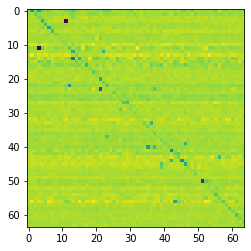

In [340]:
plt.imshow(Aij)

In [251]:
np.max(Aij)

0.0031494140625000014

In [252]:
np.min(Aij)

-0.09945068359374999

In [342]:
Cij = np.zeros([64,64])
valsC = []
for i in range(64):
    print("on i=",i)
    for j in range(64):
        if (i==j):
            Cij[i,j]=0
        else:
            Cij[i,j] = Eij(myres[0],i,j) - Ei(myres[0],i)*Ei(myres[0],j)
            valsC+=[Eij(myres[0],i,j) - Ei(myres[0],i)*Ei(myres[0],j)]

on i= 0
on i= 1
on i= 2
on i= 3
on i= 4
on i= 5
on i= 6
on i= 7
on i= 8
on i= 9
on i= 10
on i= 11
on i= 12
on i= 13
on i= 14
on i= 15
on i= 16
on i= 17
on i= 18
on i= 19
on i= 20
on i= 21
on i= 22
on i= 23
on i= 24
on i= 25
on i= 26
on i= 27
on i= 28
on i= 29
on i= 30
on i= 31
on i= 32
on i= 33
on i= 34
on i= 35
on i= 36
on i= 37
on i= 38
on i= 39
on i= 40
on i= 41
on i= 42
on i= 43
on i= 44
on i= 45
on i= 46
on i= 47
on i= 48
on i= 49
on i= 50
on i= 51
on i= 52
on i= 53
on i= 54
on i= 55
on i= 56
on i= 57
on i= 58
on i= 59
on i= 60
on i= 61
on i= 62
on i= 63


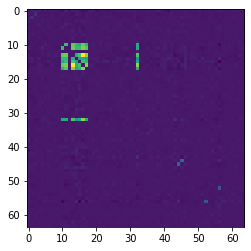

In [345]:
plt.imshow(Cij)

In [343]:
ReadE = []
for i in range(64):
    ReadE+=[0.5*(Ei(myres[0],i)+(1-Ei(myres[i+1],i)))]

In [238]:
import matplotlib as mpl
mpl.use('module://ipykernel.pylab.backend_inline')

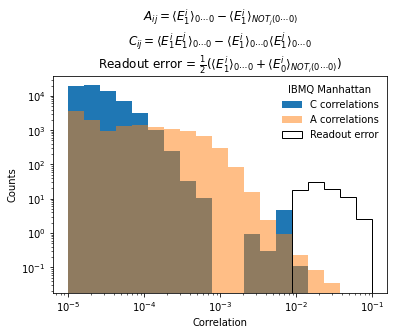

In [346]:
plt.hist(np.abs(valsC),bins=np.logspace(-5,-1,20),label="C correlations",density=True)
plt.hist(np.abs(vals),bins=np.logspace(-5,-1,20),label="A correlations",alpha=0.5,density=True)
plt.hist(np.abs(ReadE),bins=np.logspace(-5,-1,20),label="Readout error",histtype="step",color="black",density=True)
plt.legend(frameon=False,title="IBMQ Manhattan")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Correlation")
plt.ylabel("Counts")
plt.title(r"$A_{ij} = \langle E_{1}^i\rangle_{0\cdots0}-\langle E_{1}^i\rangle_{NOT_j(0\cdots0)}$"+"\n"+r"$C_{ij} = \langle E_{1}^iE_{1}^j\rangle_{0\cdots0}-\langle E_{1}^i\rangle_{0\cdots0}\langle E_{1}^j\rangle_{0\cdots0}$"+"\n"+r"Readout error = $\frac{1}{2}(\langle E_{1}^i\rangle_{0\cdots0}+\langle E_{0}^i\rangle_{NOT_i(0\cdots0)})$")
plt.savefig("Aij_Manhattan.pdf",bbox_inches='tight') #backend='pgf'

In [153]:
coupling_map = backend.configuration().coupling_map

In [7]:
from collections import defaultdict

class Graph():
    def __init__(self):
        """
        self.edges is a dict of all possible next nodes
        e.g. {'X': ['A', 'B', 'C', 'E'], ...}
        self.weights has all the weights between two nodes,
        with the two nodes as a tuple as the key
        e.g. {('X', 'A'): 7, ('X', 'B'): 2, ...}
        """
        self.edges = defaultdict(list)
        self.weights = {}
    
    def add_edge(self, from_node, to_node, weight):
        # Note: assumes edges are bi-directional
        self.edges[from_node].append(to_node)
        self.edges[to_node].append(from_node)
        self.weights[(from_node, to_node)] = weight
        self.weights[(to_node, from_node)] = weight

In [349]:
graph = Graph()

edges = []
for i in range(len(coupling_map)):
    edges+=[(str(coupling_map[i][0]),str(coupling_map[i][1]),1)]

for edge in edges:
    graph.add_edge(*edge)

In [8]:
def dijsktra(graph, initial, end):
    #https://benalexkeen.com/implementing-djikstras-shortest-path-algorithm-with-python/
    # shortest paths is a dict of nodes
    # whose value is a tuple of (previous node, weight)
    shortest_paths = {initial: (None, 0)}
    current_node = initial
    visited = set()
    
    while current_node != end:
        visited.add(current_node)
        destinations = graph.edges[current_node]
        weight_to_current_node = shortest_paths[current_node][1]

        for next_node in destinations:
            weight = graph.weights[(current_node, next_node)] + weight_to_current_node
            if next_node not in shortest_paths:
                shortest_paths[next_node] = (current_node, weight)
            else:
                current_shortest_weight = shortest_paths[next_node][1]
                if current_shortest_weight > weight:
                    shortest_paths[next_node] = (current_node, weight)
        
        next_destinations = {node: shortest_paths[node] for node in shortest_paths if node not in visited}
        if not next_destinations:
            return "Route Not Possible"
        # next node is the destination with the lowest weight
        current_node = min(next_destinations, key=lambda k: next_destinations[k][1])
    
    # Work back through destinations in shortest path
    path = []
    while current_node is not None:
        path.append(current_node)
        next_node = shortest_paths[current_node][0]
        current_node = next_node
    # Reverse path
    path = path[::-1]
    return path

In [350]:
dijsktra(graph, '0', '64')

['0',
 '1',
 '2',
 '3',
 '4',
 '11',
 '17',
 '18',
 '19',
 '25',
 '33',
 '34',
 '35',
 '40',
 '49',
 '50',
 '51',
 '54',
 '64']

In [351]:
dists = []
for i in range(64):
    for j in range(64):
        if (i==j):
            pass
        else:
            dists+=[len(dijsktra(graph, str(i), str(j)))-1]

In [352]:
vals = np.array(vals)

Text(0, 0.5, '$|A_{ij}|$')

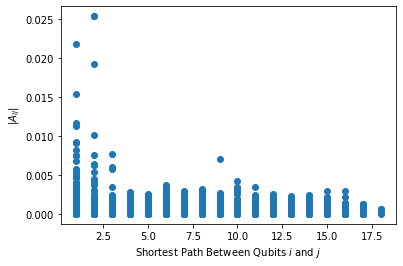

In [353]:
binns = np.linspace(0,20,10)
plt.scatter(dists,abs(vals))
#plt.plot(binns[0:-1],[np.mean(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)])
plt.xlabel("Shortest Path Between Qubits $i$ and $j$")
plt.ylabel("$|A_{ij}|$")
#plt.savefig("Aij_v_distance_Manhattan.pdf",bbox_inches='tight')

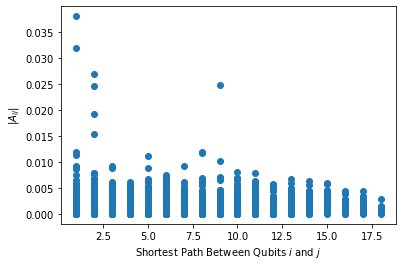

In [225]:
binns = np.linspace(0,20,10)
plt.scatter(dists,abs(vals))
#plt.plot(binns[0:-1],[np.mean(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)])
plt.xlabel("Shortest Path Between Qubits $i$ and $j$")
plt.ylabel("$|A_{ij}|$")
plt.savefig("Aij_v_distance_Manhattan.pdf",bbox_inches='tight')

/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '$|A_{ij}|$')

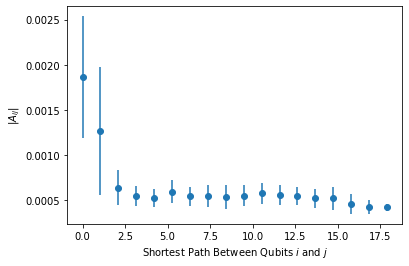

In [354]:
n = 20
binns = np.linspace(0,20,n)
plt.errorbar(binns[0:-1],[np.mean(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)],yerr=np.array([np.std(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)])/n**0.5,marker='o',ls="")
plt.xlabel("Shortest Path Between Qubits $i$ and $j$")
plt.ylabel("$|A_{ij}|$")

/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, '$|A_{ij}|$')

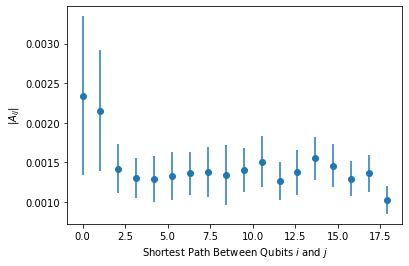

In [197]:
n = 20
binns = np.linspace(0,20,n)
plt.errorbar(binns[0:-1],[np.mean(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)],yerr=np.array([np.std(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)])/n**0.5,marker='o',ls="")
plt.xlabel("Shortest Path Between Qubits $i$ and $j$")
plt.ylabel("$|A_{ij}|$")

Text(0, 0.5, '$|A_{ij}|$')

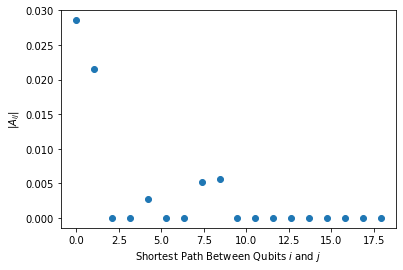

In [203]:
n = 20
binns = np.linspace(0,20,n)
plt.plot(binns[0:-1],[np.mean(abs(vals[(dists > binns[i])*(dists < binns[i+1])])>0.01) for i in range(len(binns)-1)],marker='o',ls="")
plt.xlabel("Shortest Path Between Qubits $i$ and $j$")
plt.ylabel("$|A_{ij}|$")

In [9]:
backend2 = provider.get_backend('ibmq_16_melbourne')
#coupling_map = backend.configuration().coupling_map

circs2 = []

for i in range(nmult):
    qr = QuantumRegister(15, 'qr')
    cr = ClassicalRegister(15, 'cr')
    circ = QuantumCircuit(qr, cr)

    for q in range(15):
        circ.measure(q,q)

    circ.name='nom_'+str(i)
    mapped_circuit = transpile(circ, backend=backend2, optimization_level=0)
    circs2+=[mapped_circuit]
    
for j in range(nmult):
    for i in range(15):

        qr = QuantumRegister(15, 'qr')
        cr = ClassicalRegister(15, 'cr')
        circ = QuantumCircuit(qr, cr)

        circ.x(qr[i])

        circ.name='cal_'+str(i)+"_"+str(j)

        for q in range(15):
            circ.measure(q,q)

        mapped_circuit = transpile(circ, backend=backend2, optimization_level=0)
        circs2+=[mapped_circuit]

for i in range(nmult):
    qr = QuantumRegister(15, 'qr')
    cr = ClassicalRegister(15, 'cr')
    circ = QuantumCircuit(qr, cr)
    
    for i in range(15): #was for q in range(15):
        circ.x(qr[i])

    for q in range(15):
        circ.measure(q,q)

    circ.name='nomX_'+str(i)
    mapped_circuit = transpile(circ, backend=backend2, optimization_level=0)
    circs2+=[mapped_circuit]

In [205]:
job_set2 = job_manager.run(circs2, backend=backend2, name='test_readout2', shots=8192)
print(job_set2.job_set_id())

84d7b03dc1614ba79f77b57b6c36c71f-16157546653380291


In [209]:
job_set2.statuses()

[<JobStatus.DONE: 'job has successfully run'>]

In [216]:
results2 = job_set2.results()
myres2 = {}
for i in range(17):
    myres2[i] = results2.get_counts(i)
    
for i in range(17):
    np.save("results/84d7b03dc1614ba79f77b57b6c36c71f-16157546653380291_"+str(i)+".npy",results2.get_counts(i))

In [217]:
myres2 = {}
for i in range(17):
    myres2[i] = np.load("results/84d7b03dc1614ba79f77b57b6c36c71f-16157546653380291_"+str(i)+".npy",allow_pickle=True).item()

In [218]:
Aij2 = np.zeros([15,15])
vals2 = []
for i in range(15):
    for j in range(15):
        if (i==j):
            Aij2[i,j]=0
        else:
            Aij2[i,j] = Ei(myres2[0],i) - Ei(myres2[j+1],i)
            vals2+=[Ei(myres2[0],i) - Ei(myres2[j+1],i)]
vals2 = np.array(vals2)
            
Cij2 = np.zeros([15,15])
valsC2 = []
for i in range(15):
    print("on i=",i)
    for j in range(15):
        if (i==j):
            Cij2[i,j]=0
        else:
            Cij2[i,j] = Eij(myres2[0],i,j) - Ei(myres2[0],i)*Ei(myres2[0],j)
            valsC2+=[Eij(myres2[0],i,j) - Ei(myres2[0],i)*Ei(myres2[0],j)]
            
ReadE2 = []
for i in range(15):
    ReadE2+=[0.5*(Ei(myres2[0],i)+(1-Ei(myres2[i+1],i)))]
    
coupling_map2 = backend2.configuration().coupling_map
graph2 = Graph()

edges2 = []
for i in range(len(coupling_map2)):
    edges2+=[(str(coupling_map2[i][0]),str(coupling_map2[i][1]),1)]

for edge in edges2:
    graph2.add_edge(*edge)    
    
dists2 = []
for i in range(15):
    for j in range(15):
        if (i==j):
            pass
        else:
            dists2+=[len(dijsktra(graph2, str(i), str(j)))-1]

on i= 0
on i= 1
on i= 2
on i= 3
on i= 4
on i= 5
on i= 6
on i= 7
on i= 8
on i= 9
on i= 10
on i= 11
on i= 12
on i= 13
on i= 14


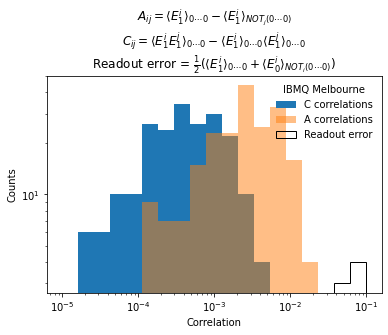

In [223]:
plt.hist(np.abs(valsC2),bins=np.logspace(-5,-1,20),label="C correlations")
plt.hist(np.abs(vals2),bins=np.logspace(-5,-1,20),label="A correlations",alpha=0.5)
plt.hist(np.abs(ReadE2),bins=np.logspace(-5,-1,20),label="Readout error",histtype="step",color="black")
plt.legend(frameon=False,title="IBMQ Melbourne")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Correlation")
plt.ylabel("Counts")
plt.title(r"$A_{ij} = \langle E_{1}^i\rangle_{0\cdots0}-\langle E_{1}^i\rangle_{NOT_j(0\cdots0)}$"+"\n"+r"$C_{ij} = \langle E_{1}^iE_{1}^j\rangle_{0\cdots0}-\langle E_{1}^i\rangle_{0\cdots0}\langle E_{1}^j\rangle_{0\cdots0}$"+"\n"+r"Readout error = $\frac{1}{2}(\langle E_{1}^i\rangle_{0\cdots0}+\langle E_{0}^i\rangle_{NOT_i(0\cdots0)})$")
plt.savefig("Aij_Melbourne.pdf",bbox_inches='tight')

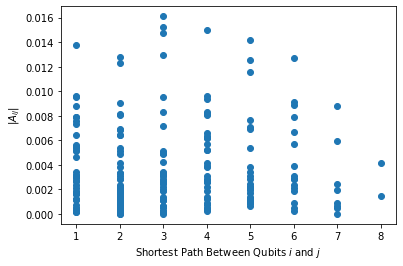

In [222]:
binns = np.linspace(0,20,10)
plt.scatter(dists2,abs(vals2))
#plt.plot(binns[0:-1],[np.mean(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)])
plt.xlabel("Shortest Path Between Qubits $i$ and $j$")
plt.ylabel("$|A_{ij}|$")
plt.savefig("Aij_v_distance_Melbourne.pdf",bbox_inches='tight')

In [11]:
job_manager = IBMQJobManager()

In [14]:
job_set = job_manager.run(circs, backend=backend, name='test_readout_10x_v2_'+str(0), shots=8192)
print(0,job_set.job_set_id())

0 8aa22a430cf04245afc53da0b09726f6-161695604188177


In [16]:
job_set2 = job_manager.run(circs2, backend=backend2, name='test_readout2_10x_v2_'+str(0), shots=8192)
print(0,job_set2.job_set_id())

0 be65b5105bfa47fea8104fa721db2648-16169560656561768


In [17]:
job_sets = {}
job_set2s = {}
for repeat in range(1,10):
    job_sets[repeat] = job_manager.run(circs, backend=backend, name='test_readout_10x_v2_'+str(repeat), shots=8192)
    print(repeat,job_sets[repeat].job_set_id())

    job_set2s[repeat] = job_manager.run(circs2, backend=backend2, name='test_readout2_10x_v2_'+str(repeat), shots=8192)
    print(repeat,job_set2s[repeat].job_set_id())

1 002a034b60da4c6ebc53a2a9d0a6a515-16169570839899478
1 6150fb4c996d4449a4fea7550f7b5aa0-1616957089487436
2 b54ee59fec444fc296a06e3b321752a7-1616957098041585
2 1d51d954b6bd49a3a6e433162639f782-1616957101612662
3 947a320ebde04587b52afff4bbe1e36e-16169571107351239
3 66bfdae5c9ea40f984cae97abc7d5025-16169571145238981
4 5ee39d903cb04b29a0e2efd9b1c5ecf4-161695712373398
4 ed7c54c40b7a49c68eb709074ade2531-1616957127501346
5 861ff09e02644085803afb6b63d53e87-1616957137066359
5 1f2b2ba18c784f6e87e0e5da8e7a9b4b-16169571408197062
6 0e5652102dd94d7f9d2a0421ce53a2c9-16169571490514581
6 4059d10524a14afb816d239fb8a1db21-1616957152236047
7 3c65271382414202b203563808bd5659-16169571605781069
7 13263a19a5c34eda8cadab43a4fd09e5-16169571646379929
8 8c817dc74f2f494f89f2f2ce70ce232a-1616957173342881
8 f525fd8e601a4ef7ac892094542675d3-1616957176616205
9 b2677f8a964b47939a77af7a4a141f9b-16169571866800451
9 7e28244435904212af2a73f55e523224-1616957190117619


In [249]:
print(0,job_set.statuses())
print(0,job_set2.statuses())
for repeat in range(1,10):
    #print(repeat,job_sets[repeat].statuses())
    print(repeat,job_set2s[repeat].statuses())

0 [<JobStatus.DONE: 'job has successfully run'>]
0 [<JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has successfully run'>]
1 [<JobStatus.DONE: 'job has successfully run'>, <JobStatus.ERROR: 'job incurred error'>, <JobStatus.ERROR: 'job incurred error'>]
2 [<JobStatus.ERROR: 'job incurred error'>, <JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has successfully run'>]
3 [<JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has successfully run'>]
4 [<JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has successfully run'>]
5 [<JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has successfully run'>]
6 [<JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has successfully run'>, <JobStatus.DONE: 'job has

In [10]:
def merge_outputs(dicts):
    #Merge counts from multiple runs on the same computer.
    output = dicts[0].copy()
    for i in range(1,len(dicts)):
        for j in dicts[i]:
            if j in output:
                output[j] += dicts[i][j]
            else:
                output[j] = dicts[i][j]
            pass
        pass
    return output
    
def compute_corrs(myres,coupling_map):
    #input a count dictionary and then outputs
    #[A,C,flatten(A),flatten(C),flatten(E),flatten(D),flatten(Q),D]
    #where E are the readout errors and D are the distances between nodes, Q is the number of connections to a given qubit
    
    #first, figure out how many qubits there are.
    nq = 0
    for j in myres[0]:
        nq = len(j)
        break
        
    Aij = np.zeros([nq,nq])
    vals = []
    for i in range(nq):
        print("Computing Aij, on i=",i)
        for j in range(nq):
            if (i==j):
                Aij[i,j]= 0
            else:
                Aij[i,j] = Ei(myres[0],i) - Ei(myres[j+1],i)
                vals+=[Ei(myres[0],i) - Ei(myres[j+1],i)]
    
    Cij = np.zeros([nq,nq])
    valsC = []
    for i in range(nq):
        print("Computing Cij, on i=",i)
        for j in range(nq):
            if (i==j):
                Cij[i,j]=0
            else:
                Cij[i,j] = Eij(myres[0],i,j) - Ei(myres[0],i)*Ei(myres[0],j)
                valsC+=[Eij(myres[0],i,j) - Ei(myres[0],i)*Ei(myres[0],j)]
    
    ReadE = []
    for i in range(nq):
        ReadE+=[0.5*(Ei(myres[0],i)+(1-Ei(myres[i+1],i)))]
    
    graph = Graph()

    edges = []
    for i in range(len(coupling_map)):
        edges+=[(str(coupling_map[i][0]),str(coupling_map[i][1]),1)]

    for edge in edges:
        graph.add_edge(*edge)
        
    dists = []
    D = np.zeros([nq,nq])
    for i in range(nq):
        for j in range(nq):
            if (i==j):
                D[i,j]=0
                pass
            else:
                dists+=[len(dijsktra(graph, str(i), str(j)))]
                D[i,j]=len(dijsktra(graph, str(i), str(j)))
                
    dists = np.array(dists)
    
    qs = np.array([sum(np.array(coupling_map)[:,0]==i) for i in range(nq)])
    
    return [Aij,Cij,vals,valsC,ReadE,dists,qs,D]

In [35]:
merge_outputs([{"0001":2,"2":1},{"1":1}])

{'0001': 2, '2': 1, '1': 1}

In [89]:
results = job_set.results() #Manhattan
results2 = job_set2.results() #Melbourne

In [167]:
combined_results = {}
for i in range(660):
    combined_results[i] = results.get_counts(i)
    
combined_results2 = {}
for i in range(170):
    combined_results2[i] = results2.get_counts(i)

In [168]:
for repeat in range(1,10):
    print(repeat)
    for i in range(660):
        results_hold = job_sets[repeat].results()
        combined_results[i] = merge_outputs([combined_results[i],results_hold.get_counts(i)])

1
2
3
4
5
6
7
8
9


In [170]:
combined_results_filtered = {}

for i in range(nmult):
    if (i==0):
        combined_results_filtered[0] = combined_results[i].copy()
    else:
        for st in combined_results[i]:
            if st in combined_results_filtered[0]:
                combined_results_filtered[0][st]+=combined_results[i][st]
            else:
                combined_results_filtered[0][st]=combined_results[i][st]

print(sum([combined_results_filtered[0][i] for i in combined_results_filtered[0].keys()]))
                
for j in range(nmult):
    for i in range(64):
        k = i+j*64+nmult
        if (j==0):
            combined_results_filtered[i+1] = combined_results[k].copy()
        else:
            for st in combined_results[k]:
                if st in combined_results_filtered[i+1]:
                    combined_results_filtered[i+1][st]+=combined_results[k][st]
                else:
                    combined_results_filtered[i+1][st]=combined_results[k][st]
                    
print(sum([combined_results_filtered[0][i] for i in combined_results_filtered[0].keys()]))                    
                    
for i in range(660-nmult,660):
    if (i==660-nmult):
        combined_results_filtered[65] = combined_results[i].copy()
    else:
        for st in combined_results[i]:
            if st in combined_results_filtered[65]:
                combined_results_filtered[65][st]+=combined_results[i][st]
            else:
                combined_results_filtered[65][st]=combined_results[i][st]
                
print(sum([combined_results_filtered[0][i] for i in combined_results_filtered[0].keys()]))

819200
819200
819200


In [171]:
combined_results2_filtered = {}

for i in range(nmult):
    if (i==0):
        combined_results2_filtered[0] = combined_results2[i].copy()
    else:
        for st in combined_results2[i]:
            if st in combined_results2_filtered[0]:
                combined_results2_filtered[0][st]+=combined_results2[i][st]
            else:
                combined_results2_filtered[0][st]=combined_results2[i][st]

for j in range(nmult):
    for i in range(15):
        k = i+j*15+nmult
        if (j==0):
            combined_results2_filtered[i+1] = combined_results2[k].copy()
        else:
            for st in combined_results2[k]:
                if st in combined_results2_filtered[i+1]:
                    combined_results2_filtered[i+1][st]+=combined_results2[k][st]
                else:
                    combined_results2_filtered[i+1][st]=combined_results2[k][st]
                    
for i in range(170-nmult,170):
    if (i==170-nmult):
        combined_results2_filtered[16] = combined_results2[i].copy()
    else:
        for st in combined_results2[i]:
            if st in combined_results2_filtered[16]:
                combined_results2_filtered[16][st]+=combined_results2[i][st]
            else:
                combined_results2_filtered[16][st]=combined_results2[i][st]

In [172]:
for i in range(66):
    np.save("results/combined_results_filtered_"+str(i)+".npy",combined_results_filtered[i])

In [173]:
for i in range(16):
    np.save("results/combined_results2_filtered_"+str(i)+".npy",combined_results2_filtered[i])

In [20]:
combined_results_filtered = {}
combined_results2_filtered = {}

for i in range(66):
    combined_results_filtered[i] = np.load("results/combined_results_filtered_"+str(i)+".npy",allow_pickle=True).item()
    
for i in range(16):
    combined_results2_filtered[i] = np.load("results/combined_results2_filtered_"+str(i)+".npy",allow_pickle=True).item()

In [22]:
sum([combined_results[0][i] for i in combined_results_filtered[0].keys()])

NameError: name 'combined_results' is not defined

In [23]:
sum([combined_results_filtered[0][i] for i in combined_results_filtered[0].keys()])

819200

In [24]:
Manhattan_results = compute_corrs(combined_results_filtered,backend.configuration().coupling_map)

Computing Aij, on i= 0
Computing Aij, on i= 1
Computing Aij, on i= 2
Computing Aij, on i= 3
Computing Aij, on i= 4
Computing Aij, on i= 5
Computing Aij, on i= 6
Computing Aij, on i= 7
Computing Aij, on i= 8
Computing Aij, on i= 9
Computing Aij, on i= 10
Computing Aij, on i= 11
Computing Aij, on i= 12
Computing Aij, on i= 13
Computing Aij, on i= 14
Computing Aij, on i= 15
Computing Aij, on i= 16
Computing Aij, on i= 17
Computing Aij, on i= 18
Computing Aij, on i= 19
Computing Aij, on i= 20
Computing Aij, on i= 21
Computing Aij, on i= 22
Computing Aij, on i= 23
Computing Aij, on i= 24
Computing Aij, on i= 25
Computing Aij, on i= 26
Computing Aij, on i= 27
Computing Aij, on i= 28
Computing Aij, on i= 29
Computing Aij, on i= 30
Computing Aij, on i= 31
Computing Aij, on i= 32
Computing Aij, on i= 33
Computing Aij, on i= 34
Computing Aij, on i= 35
Computing Aij, on i= 36
Computing Aij, on i= 37
Computing Aij, on i= 38
Computing Aij, on i= 39
Computing Aij, on i= 40
Computing Aij, on i= 41
Co

In [25]:
Melbourne_results = compute_corrs(combined_results2_filtered,backend2.configuration().coupling_map)

Computing Aij, on i= 0
Computing Aij, on i= 1
Computing Aij, on i= 2
Computing Aij, on i= 3
Computing Aij, on i= 4
Computing Aij, on i= 5
Computing Aij, on i= 6
Computing Aij, on i= 7
Computing Aij, on i= 8
Computing Aij, on i= 9
Computing Aij, on i= 10
Computing Aij, on i= 11
Computing Aij, on i= 12
Computing Aij, on i= 13
Computing Aij, on i= 14
Computing Cij, on i= 0
Computing Cij, on i= 1
Computing Cij, on i= 2
Computing Cij, on i= 3
Computing Cij, on i= 4
Computing Cij, on i= 5
Computing Cij, on i= 6
Computing Cij, on i= 7
Computing Cij, on i= 8
Computing Cij, on i= 9
Computing Cij, on i= 10
Computing Cij, on i= 11
Computing Cij, on i= 12
Computing Cij, on i= 13
Computing Cij, on i= 14


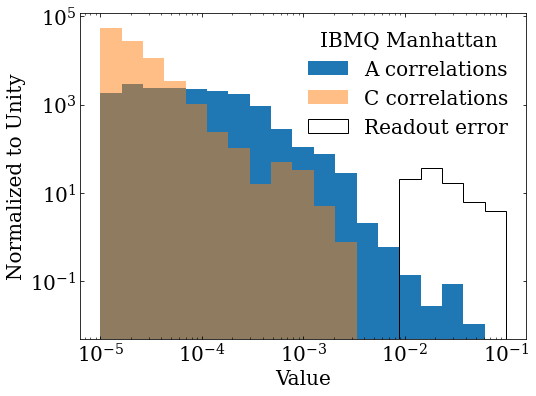

In [30]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(np.abs(Manhattan_results[2]),bins=np.logspace(-5,-1,20),label="A correlations",density=True)
plt.hist(np.abs(Manhattan_results[3]),bins=np.logspace(-5,-1,20),label="C correlations",alpha=0.5,density=True)
plt.hist(np.abs(Manhattan_results[4]),bins=np.logspace(-5,-1,20),label="Readout error",histtype="step",color="black",density=True)
plt.legend(frameon=False,title="IBMQ Manhattan")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Value")
plt.ylabel("Normalized to Unity")
#plt.title(r"$A_{ij} = \langle E_{1}^i\rangle_{0\cdots0}-\langle E_{1}^i\rangle_{NOT_j(0\cdots0)}$"+"\n"+r"$C_{ij} = \langle E_{1}^iE_{1}^j\rangle_{0\cdots0}-\langle E_{1}^i\rangle_{0\cdots0}\langle E_{1}^j\rangle_{0\cdots0}$"+"\n"+r"Readout error = $\frac{1}{2}(\langle E_{1}^i\rangle_{0\cdots0}+\langle E_{0}^i\rangle_{NOT_i(0\cdots0)})$")
plt.savefig("Aij_Manhattan.pdf",bbox_inches='tight') #backend='pgf'

No handles with labels found to put in legend.


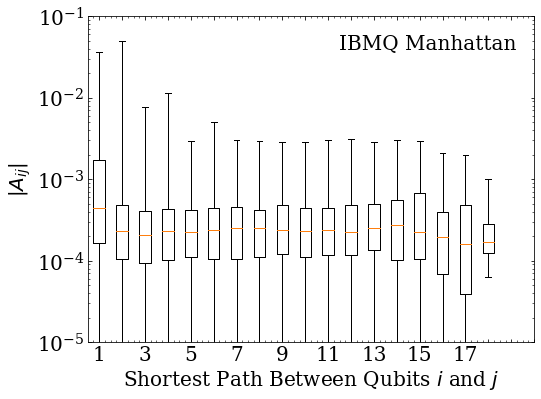

In [82]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

vals = np.array(Manhattan_results[2])
dists = Manhattan_results[5]
n = 20
binns = np.array([i*1.0001 for i in range(n)])+1

_=plt.boxplot([abs(vals[(dists > binns[i])*(dists < binns[i+1])]) for i in range(len(binns)-1)],whis=[0,100])
plt.xticks(binns,["1","","3","","5","","7","","9","","11","","13","","15","","17"])
plt.yscale("log")
plt.xlabel("Shortest Path Between Qubits $i$ and $j$")
plt.ylabel("$|A_{ij}|$")
plt.legend(frameon=False,title="IBMQ Manhattan")
plt.ylim([1e-5,1e-1])
plt.savefig("Aij_distance_Manhattan.pdf",bbox_inches='tight')

In [62]:
min(dists)

2

/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels f

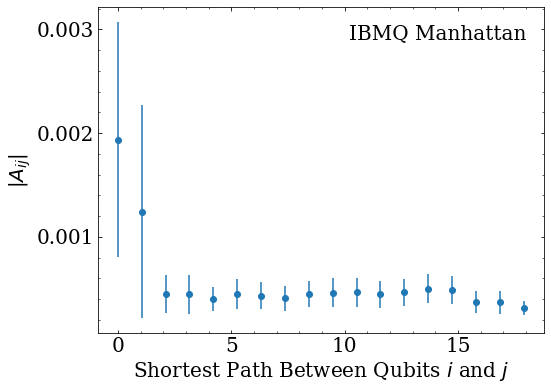

In [210]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

n = 20
binns = np.linspace(0,20,n)
vals = np.array(Manhattan_results[2])
dists = Manhattan_results[5]
plt.errorbar(binns[0:-1],[np.mean(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)],yerr=np.array([np.std(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)])/n**0.5,marker='o',ls="")
plt.xlabel("Shortest Path Between Qubits $i$ and $j$")
plt.ylabel("$|A_{ij}|$")
plt.locator_params(axis='y', nbins=5)
plt.legend(frameon=False,title="IBMQ Manhattan")
plt.savefig("Aij_distance_Manhattan.pdf",bbox_inches='tight')

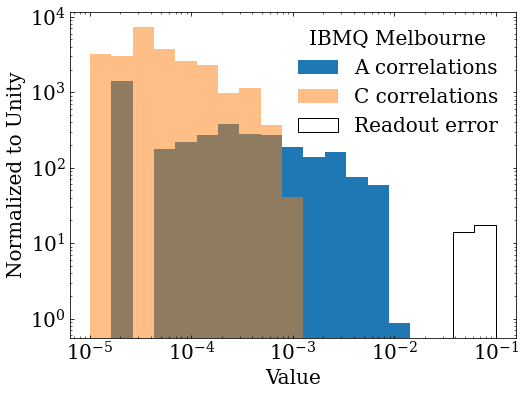

In [29]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(np.abs(Melbourne_results[2]),bins=np.logspace(-5,-1,20),label="A correlations",density=True)
plt.hist(np.abs(Melbourne_results[3]),bins=np.logspace(-5,-1,20),label="C correlations",alpha=0.5,density=True)
plt.hist(np.abs(Melbourne_results[4]),bins=np.logspace(-5,-1,20),label="Readout error",histtype="step",color="black",density=True)
plt.legend(frameon=False,title="IBMQ Melbourne")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Value")
plt.ylabel("Normalized to Unity")
#plt.title(r"$A_{ij} = \langle E_{1}^i\rangle_{0\cdots0}-\langle E_{1}^i\rangle_{NOT_j(0\cdots0)}$"+"\n"+r"$C_{ij} = \langle E_{1}^iE_{1}^j\rangle_{0\cdots0}-\langle E_{1}^i\rangle_{0\cdots0}\langle E_{1}^j\rangle_{0\cdots0}$"+"\n"+r"Readout error = $\frac{1}{2}(\langle E_{1}^i\rangle_{0\cdots0}+\langle E_{0}^i\rangle_{NOT_i(0\cdots0)})$")
plt.savefig("Aij_Melbourne.pdf",bbox_inches='tight') #backend='pgf'

No handles with labels found to put in legend.


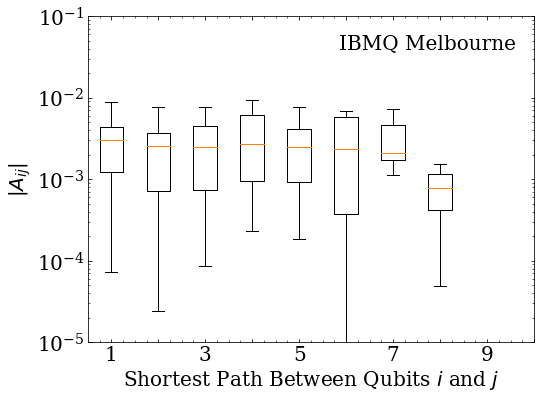

In [81]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

vals = np.array(Melbourne_results[2])
dists = Melbourne_results[5]
n = 10
binns = np.array([i*1.0001 for i in range(n)])+1

_=plt.boxplot([abs(vals[(dists > binns[i])*(dists < binns[i+1])]) for i in range(len(binns)-1)],whis=[0,100])
plt.xticks(binns,["1","","3","","5","","7","","9","","11","","13","","15","","17"])
plt.yscale("log")
plt.xlabel("Shortest Path Between Qubits $i$ and $j$")
plt.ylabel("$|A_{ij}|$")
plt.legend(frameon=False,title="IBMQ Melbourne")
plt.ylim([1e-5,1e-1])
plt.savefig("Aij_distance_Melbourne.pdf",bbox_inches='tight')

/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
No handles with labels f

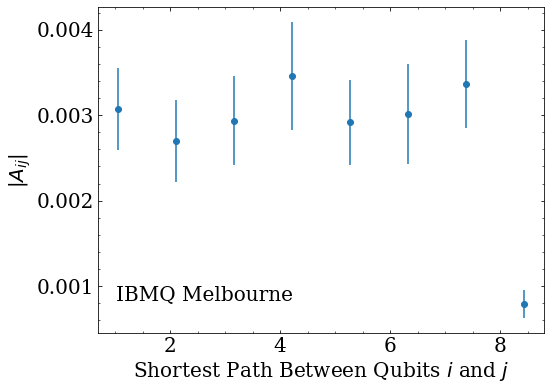

In [209]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

n = 20
binns = np.linspace(0,20,n)
vals = np.array(Melbourne_results[2])
dists = Melbourne_results[5]
plt.errorbar(binns[0:-1],[np.mean(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)],yerr=np.array([np.std(abs(vals[(dists > binns[i])*(dists < binns[i+1])])) for i in range(len(binns)-1)])/n**0.5,marker='o',ls="")
plt.xlabel("Shortest Path Between Qubits $i$ and $j$")
plt.ylabel("$|A_{ij}|$")
plt.locator_params(axis='y', nbins=5)
plt.legend(frameon=False,title="IBMQ Melbourne",loc="lower left")
plt.savefig("Aij_distance_Melbourne.pdf",bbox_inches='tight')

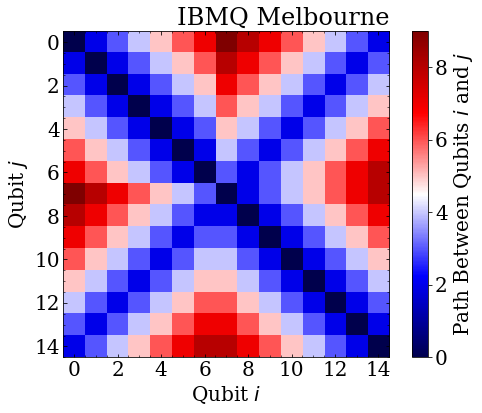

In [248]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=10)
ax0.minorticks_on()

c = plt.imshow(Melbourne_results[-1],cmap='seismic')
cb = fig.colorbar(c, ax=ax0)
cb.ax.set_ylabel('Path Between Qubits $i$ and $j$')
plt.title("IBMQ Melbourne",loc="right")

plt.xlabel("Qubit $i$")
plt.ylabel("Qubit $j$")
plt.savefig("Dij_distance_Melbourne.pdf",bbox_inches='tight')

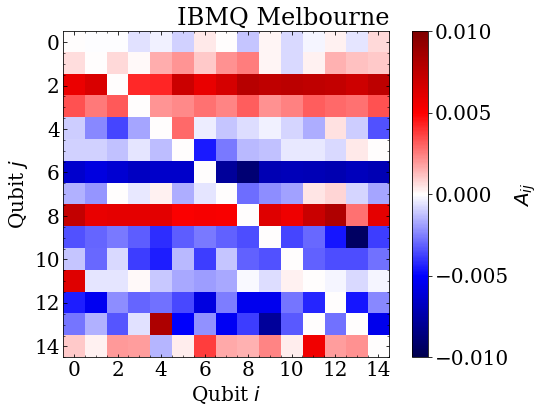

In [247]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=10)
ax0.minorticks_on()

c = plt.imshow(Melbourne_results[0],vmin=-0.01,vmax=0.01,cmap='seismic')
cb = fig.colorbar(c, ax=ax0)
cb.ax.set_ylabel('$A_{ij}$')
cb.set_ticks([-0.01,-0.005,0,0.005,0.01])
plt.title("IBMQ Melbourne",loc="right")

plt.xlabel("Qubit $i$")
plt.ylabel("Qubit $j$")
plt.savefig("Aij_across_Melbourne.pdf",bbox_inches='tight')

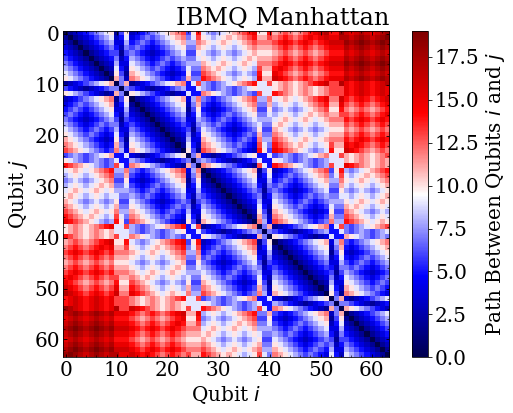

In [245]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=10)
ax0.minorticks_on()

c = plt.imshow(Manhattan_results[-1],cmap='seismic')
cb = fig.colorbar(c, ax=ax0)
cb.ax.set_ylabel('Path Between Qubits $i$ and $j$')
plt.title("IBMQ Manhattan",loc="right")

plt.xlabel("Qubit $i$")
plt.ylabel("Qubit $j$")
plt.savefig("Dij_distance_Manhattan.pdf",bbox_inches='tight')

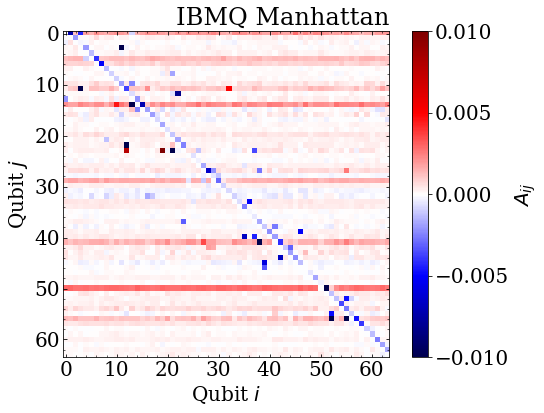

In [90]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=10)
ax0.minorticks_on()

c = plt.imshow(Manhattan_results[0],vmin=-0.01,vmax=0.01,cmap='seismic')
cb = fig.colorbar(c, ax=ax0)
cb.ax.set_ylabel('$A_{ij}$')
cb.set_ticks([-0.01,-0.005,0,0.005,0.01])
plt.title("IBMQ Manhattan",loc="right")

plt.xlabel("Qubit $i$")
plt.ylabel("Qubit $j$")
plt.savefig("Aij_across_Manhattan.pdf",bbox_inches='tight')

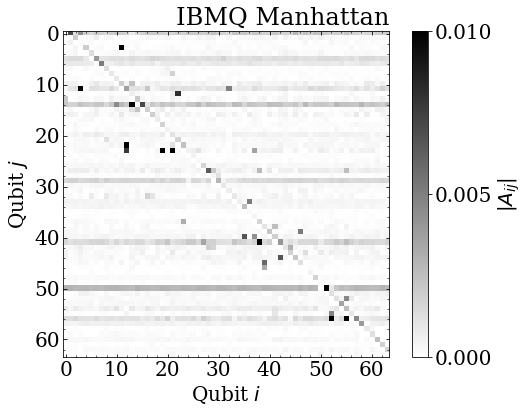

In [89]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='x', nbins=10)
plt.locator_params(axis='y', nbins=10)
ax0.minorticks_on()

c = plt.imshow(np.abs(Manhattan_results[0]),vmin=0.0,vmax=0.01,cmap='binary')
cb = fig.colorbar(c, ax=ax0)
cb.ax.set_ylabel('$|A_{ij}|$')
cb.set_ticks([-0.01,-0.005,0,0.005,0.01])
plt.title("IBMQ Manhattan",loc="right")

plt.xlabel("Qubit $i$")
plt.ylabel("Qubit $j$")
plt.savefig("Aij_across_Manhattan_Gray.pdf",bbox_inches='tight')